<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-import" data-toc-modified-id="Data-import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data import</a></span></li><li><span><a href="#Random-Forest-analysis" data-toc-modified-id="Random-Forest-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Random Forest analysis</a></span><ul class="toc-item"><li><span><a href="#get-the-X-and-y-arrays" data-toc-modified-id="get-the-X-and-y-arrays-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>get the X and y arrays</a></span></li><li><span><a href="#Extract-feature-importance-from-the-RF-runs" data-toc-modified-id="Extract-feature-importance-from-the-RF-runs-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Extract feature importance from the RF runs</a></span></li><li><span><a href="#Permutations-to-extract-p-values-for-each-metabolite" data-toc-modified-id="Permutations-to-extract-p-values-for-each-metabolite-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Permutations to extract p-values for each metabolite</a></span></li><li><span><a href="#Calculate-p-values" data-toc-modified-id="Calculate-p-values-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Calculate p-values</a></span></li><li><span><a href="#Write-final-results-to-file" data-toc-modified-id="Write-final-results-to-file-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Write final results to file</a></span></li><li><span><a href="#Plots-of-feature-importance-averages-and-standard-deviations" data-toc-modified-id="Plots-of-feature-importance-averages-and-standard-deviations-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Plots of feature importance averages and standard deviations</a></span></li></ul></li><li><span><a href="#Plots-(heatmap-and-sum-by-class)" data-toc-modified-id="Plots-(heatmap-and-sum-by-class)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plots (heatmap and sum by class)</a></span><ul class="toc-item"><li><span><a href="#Heatmap" data-toc-modified-id="Heatmap-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Heatmap</a></span></li><li><span><a href="#Make-plots-for-each-candidate-summing-over-the-class" data-toc-modified-id="Make-plots-for-each-candidate-summing-over-the-class-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Make plots for each candidate summing over the class</a></span></li></ul></li><li><span><a href="#Export-results" data-toc-modified-id="Export-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Export results</a></span></li></ul></div>

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import random 

# custom functions
from helper_functions import extract_feature_importance_avg_and_sd_from_multiple_random_forest_runs
from helper_functions import extract_feature_importances_from_random_forests_on_permuted_y
from helper_functions import get_significant_features
from helper_functions import plot_candidate_heatmap
from helper_functions import plot_candidate_sum_by_class
from helper_functions import get_sum_by_class_df


from helper_functions import single_random_forest_run

# Data import

In [19]:
df = pd.read_csv("../Figure_3/acylsugar_analytics/acylsugar_summary.tsv",sep="\t",index_col=0)
df.head()

,wf,thrips,Glucose_2,Glucose_3,Glucose_4,Glucose_5,Sucrose_1,Sucrose_2,Sucrose_3,Sucrose_4,Sucrose_5,total_glucose,total_sucrose
sample,,,,,,,,,,,,,
MM,non-toxic,non-toxic,0.0,11.591665,70.068765,44.355994,1.264401,1.451547,8.359466,371.798175,126.739905,126.016425,509.613494
LA4024,non-toxic,non-toxic,0.0,1.260663,2.429888,0.000000,0.000000,0.446886,10.589788,1.004579,0.000000,3.690551,12.041254
LA1578,non-toxic,non-toxic,0.0,9.078842,350.776672,321.914205,0.000000,0.897126,21.280534,1408.536948,690.574564,681.769720,2121.289171
LA1278,non-toxic,toxic,0.0,23.279711,118.584926,112.817646,0.380556,0.639418,14.521886,628.620406,215.159937,254.682283,859.322203
LA1954,toxic,non-toxic,0.0,6.368703,300.504894,241.461846,0.000000,3.161044,104.294512,1145.804123,481.086098,548.335442,1734.345776


# Random Forest analysis 

## get the X and y arrays

In [20]:
# get thrips classes
y = df["thrips"].tolist()
stratify_info = df['thrips'].map({'non-toxic': 0, 'toxic': 1})

# get matrix X of volatile values
X = df.iloc[:,2:]

## Extract feature importance from the RF runs

In [21]:
# generates a list with three elements
# first element average of the feature importance 
# second element standard deviation of the feature importance
# third element accuracy score of the Random Forest model
feature_importances  = extract_feature_importance_avg_and_sd_from_multiple_random_forest_runs(
    X,
    y,
    nb_of_splits=6,
    nb_of_trees=1000,
    nb_of_runs=5,
    njobs=2
)

In [22]:
mean_varimportance = feature_importances[0].mean(axis=1)
# sum the variances (=squared std) and then take the mean
pooled_std = np.sqrt((feature_importances[1]**2).mean(axis=1))
# create panda for convenience
yerr = pd.concat([mean_varimportance-2*pooled_std, mean_varimportance,mean_varimportance+2*pooled_std],axis=1)

In [23]:
# accuracy score of the model
print("This is the global accuracy score of the model:",feature_importances[2])

This is the global accuracy score of the model: 0.57


## Permutations to extract p-values for each metabolite 

In [17]:
# compute feature importances based on permuted y values
feature_importance_perm = extract_feature_importances_from_random_forests_on_permuted_y(
    X,
    y,
    nb_of_splits=6,
    nb_of_trees=1000,
    nperm=100,
    randomSeed=1234,
    njobs=2
)

,perm0,perm1,perm2,perm3,perm4,perm5,perm6,perm7,perm8,perm9,...,perm90,perm91,perm92,perm93,perm94,perm95,perm96,perm97,perm98,perm99
Glucose_2,0.032658,0.050086,0.041463,0.052154,0.037105,0.028200,0.046761,0.048662,0.096658,0.031010,...,0.030592,0.063902,0.033027,0.035900,0.051319,0.041121,0.041247,0.038792,0.028195,0.059579
Glucose_3,0.092636,0.089333,0.182691,0.099689,0.107137,0.118951,0.237562,0.131536,0.135314,0.141806,...,0.082575,0.062794,0.128019,0.099122,0.094144,0.128373,0.102732,0.105404,0.085783,0.097857
Glucose_4,0.064017,0.098526,0.083066,0.097158,0.088460,0.124759,0.056625,0.078226,0.080152,0.092161,...,0.127832,0.144482,0.079211,0.122232,0.096460,0.090174,0.093486,0.084985,0.068691,0.117591
Glucose_5,0.056630,0.093309,0.063522,0.076517,0.090728,0.081301,0.057447,0.058546,0.064827,0.108539,...,0.103679,0.140555,0.066798,0.093840,0.085232,0.105459,0.090947,0.079635,0.068249,0.094447
Sucrose_1,0.209117,0.071763,0.125206,0.085917,0.091426,0.079316,0.055901,0.058688,0.066604,0.078507,...,0.126922,0.066870,0.054310,0.144294,0.069375,0.052914,0.060396,0.110039,0.065915,0.091084
Sucrose_2,0.078780,0.101032,0.101651,0.092543,0.095894,0.085582,0.102226,0.067643,0.115592,0.085057,...,0.084570,0.095009,0.105689,0.085515,0.089924,0.063057,0.083592,0.081575,0.106502,0.086540
Sucrose_3,0.183700,0.098231,0.095508,0.106078,0.116394,0.099465,0.136390,0.112045,0.116226,0.102835,...,0.058322,0.094112,0.163995,0.091890,0.102915,0.112913,0.151402,0.194152,0.086646,0.083437
Sucrose_4,0.076839,0.085424,0.065300,0.100202,0.104120,0.085919,0.060736,0.102549,0.066598,0.072183,...,0.104560,0.068142,0.114992,0.066311,0.119563,0.124872,0.084698,0.073082,0.195479,0.107208
Sucrose_5,0.059005,0.075129,0.103067,0.118489,0.117719,0.104670,0.059083,0.064650,0.066902,0.139778,...,0.124059,0.130337,0.069116,0.094368,0.102711,0.101758,0.126004,0.067483,0.076209,0.089058
total_glucose,0.061521,0.126770,0.072962,0.093652,0.076725,0.108083,0.107918,0.137664,0.112481,0.080102,...,0.083380,0.073613,0.104126,0.086668,0.087867,0.097284,0.085888,0.087568,0.085672,0.076171


In [25]:
feature_importance_perm.iloc[0:5,0:5]

,perm0,perm1,perm2,perm3,perm4
Glucose_2,0.032658,0.050086,0.041463,0.052154,0.037105
Glucose_3,0.092636,0.089333,0.182691,0.099689,0.107137
Glucose_4,0.064017,0.098526,0.083066,0.097158,0.088460
Glucose_5,0.056630,0.093309,0.063522,0.076517,0.090728
Sucrose_1,0.209117,0.071763,0.125206,0.085917,0.091426


In [26]:
feature_importance_perm_250 = extract_feature_importances_from_random_forests_on_permuted_y(
    X,
    y,
    nb_of_splits=6,
    nb_of_trees=1000,
    nperm=250,
    randomSeed=4567,
    njobs=2
)

In [27]:
feature_importance_perm_250.iloc[0:5,0:5]

,perm0,perm1,perm2,perm3,perm4
Glucose_2,0.039296,0.028030,0.030680,0.041866,0.035180
Glucose_3,0.084533,0.126409,0.121878,0.115674,0.122935
Glucose_4,0.081652,0.170275,0.088718,0.086107,0.078813
Glucose_5,0.068594,0.128828,0.070853,0.070026,0.075147
Sucrose_1,0.083198,0.057793,0.075130,0.080396,0.136536


In [ ]:
feature_importance_perm_500 = extract_feature_importances_from_random_forests_on_permuted_y(
    X,
    y,
    nb_of_splits=6,
    nb_of_trees=1000,
    nperm=500,
    randomSeed=8910,
    njobs=2
)

## Calculate p-values

**How?** By comparing the average feature importance from the original dataset to the distribution of feature importance based on N permutations.   

In [28]:
all_pvalues = get_significant_features(X,
                                  original_feature_importances=feature_importances,
                                  permuted_feature_importances=feature_importance_perm,
                                  pval=0.05)

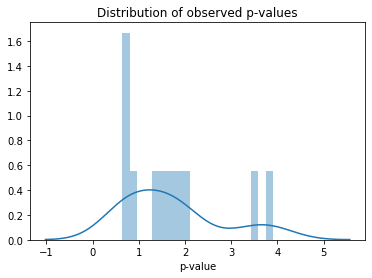

In [29]:
sns.distplot(all_pvalues.iloc[:,0].astype('float'),20)
plt.title('Distribution of observed p-values');

## Select significant variables

In [30]:
# Select significant variables
signif = all_pvalues.loc[(all_pvalues.iloc[:,0]<0.05) & (all_pvalues.iloc[:,3]<0.5)]
print(signif.shape[0],"significant candidates were identified")

0 significant candidates were identified


## Plots of feature importance averages and standard deviations

These plots show the Random Forest feature importance average and standard deviation for each significant metabolic candidates. Significant metabolic candidates should have their average feature importance different from the distribution of the random feature importances (estimated by the permutations).

In addition, the feature importance standard deviation should not be too important (e.g. relative standard deviation < 50%) as it might impairs its generability to distinguish its importance to distinguish between "toxic" from "non-toxic" genotypes.

Average and standard deviation for each feature are estimate from 5 independent Random Forest runs.

In [31]:
nrplots = len(signif.index.values)
fig = plt.figure(figsize=([3,12]),dpi=150)
ax = fig.subplots(nrows=nrplots,ncols=1)

#yerr = pd.concat([mean_varimportance-2*pooled_std, mean_varimportance,mean_varimportance+2*pooled_std],axis=1)

for i in range(nrplots):                
    plt.subplot(ax[i])
    sns.distplot(feature_importance_perm.loc[signif.index.values[i],:],bins=10,ax=ax[i])
    sns.distplot(feature_importance_perm_250.loc[signif.index.values[i],:],bins=10,ax=ax[i])
    sns.distplot(feature_importance_perm_500.loc[signif.index.values[i],:],bins=10,ax=ax[i])
    plt.plot(yerr.loc[signif.index.values[i],1],0,yerr.loc[signif.index.values[i],1],50,'^')
    plt.plot(yerr.loc[signif.index.values[i],0],0,yerr.loc[signif.index.values[i],0],50,'^')
    plt.plot(yerr.loc[signif.index.values[i],2],0,yerr.loc[signif.index.values[i],2],50,'v')

    
plt.tight_layout()

<Figure size 450x1800 with 0 Axes>

# Plots (heatmap and sum by class)

## Heatmap
To display a heatmap that shows the rows of the non-toxic genotypes followed by the rows of the toxic genotypes.

In [13]:
# drops the wf columns
df_thrips = df.drop("wf",axis=1) 

# plot
plot_candidate_heatmap(
    df=df_thrips,
    class_col="thrips",
    significant=signif.index.values,
    log=True
)

ValueError: zero-size array to reduction operation minimum which has no identity

## Make plots for each candidate summing over the class

ValueError: min() arg is an empty sequence

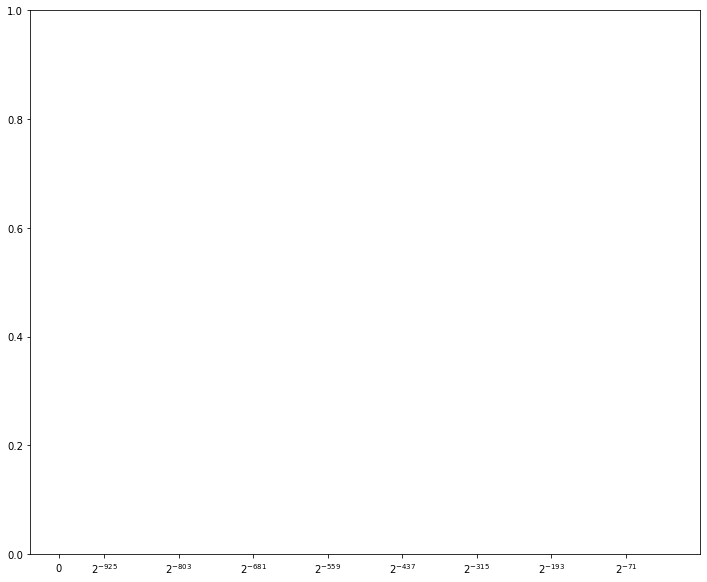

In [14]:
plot_candidate_sum_by_class(
    df = df_thrips,
    class_col = "thrips",
    significant=signif.index.values
)

# Export results

In [15]:
# write to table
signif.to_csv("../Table3/acylsugar_backbone_vs_thrips.tsv",sep="\t")

ValueError: min() arg is an empty sequence

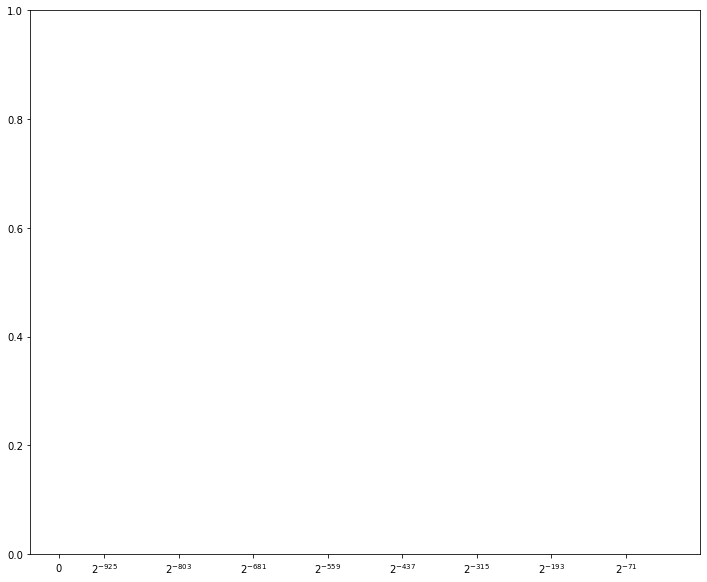

In [16]:
# save barplot figure
plot_candidate_sum_by_class(
   df = df_thrips,
   class_col = "thrips",
   significant=signif.index.values
)
plt.savefig('Figure5F_acylsugar_backbone_vs_thrips.png',format='png')
plt.savefig('Figure5F_acylsugar_backbone_vs_thrips.svg',format='svg')